# Homework 2: What do the SARS-Cov-2 genes do?

In the first homework, we wrote an algorithm to retrieve ORFs from the SARS-CoV-2 genome. Some retrieved ORFs may correspond to the actual genes, some were there by chance, and some because the start codon also encodes for methionine, so the retrieved ORF was a (short) part of the more extended coding sequence. We used protein hydrophobicity to find potential transmembrane proteins. But what about other types of proteins? How can we tell which ORFs correspond to the actual genes?

We will answer the question above in the bioinformatics way and lean to what we know about evolution. If two species are morphologically different, their genetic material must also differ substantially. Right? Not exactly. Evolution conserved many genes crucial for survival. The degree of conservation is surprising. For example, while we would expect to share many genes with the chimpanzee, our closest relative, we would expect almost no similarity in our genetic material with bananas. The numbers tell us otherwise. While sharing 96% of our genes with the chimpanzee, we also share 60% of our genes with bananas! These similar genes in humans and bananas encode proteins that carry similar functions.

Two genes with similar sequences may perform similar functions. Genes like these are called homologous genes. Or, more precisely, in our case, these would be orthologous genes (see the figure below). A pair of orthologous genes are genes from two related species originating from a common ancestor (e.g., humans and chimpanzees). Due to the evolution, the two nucleotide or protein sequences might differ slightly but not overwhelmingly.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Ortholog_paralog_analog_%28homologs%29.svg/1200px-Ortholog_paralog_analog_%28homologs%29.svg.png" width="500">
</div>

*Author: Thomas Shafee, Licence: CC BY 4.0*

The human-banana example demonstrates that these two organisms don't have to be that closely related! If we tried to determine the gene function in humans using bananas as a reference, we could infer the role of over 60% of the genes. However, using two closely related organisms would undoubtedly give us more robust results. We would be better off choosing the genome of a mouse or a chimpanzee as our reference.

Scientists have studied hundreds of viruses and determined the functions of most of their genes. Using viruses similar in sequence to SARS-Cov-2, we can characterize the SARS-CoV-2 ORFs we found in our first homework and determine if they are the actual genes, and think about their function. Knowing what each gene does might help us find a way to fight the infection and potentially even find treatments for COVID-19. 

In [1]:
import numpy as np
from Bio import Entrez
from Bio import SeqIO
import matplotlib.pyplot as plt

In [2]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

Let's let the nice folks at NCBI know who we are.

In [3]:
Entrez.email = "<mm9520@student.uni-lj.si"

## Finding SARS-CoV-2's closest relatives

In the first part of this assignment, we will analyze several coronavirus genomes to determine which are most similar to SARS-CoV-2. We will then use the viruses with the most similar sequence as reference genomes to assign functions to SARS-CoV-2 ORFs.

To find the closest reference genomes, we will align the SARS-CoV-2 sequence to each candidate coronavirus genome. The virus genomes with the highest alignment scores will be our most closely-related viruses.

Notice that computing an alignment between two sequences of length $N$ and $M$ requires the computation of a dynamic programming table with $N \cdot M$ entries. The size of this matrix is sufficiently small for short sequences. But even the short genomes, like viral genomes, are generally too long for this approach. Instead of computing similarities from the entire genomes, we will only focus on the spike protein sequence. In general, we would prefer to align the whole nucleotide sequences, but for this assignment, considering only a spike protein will be sufficient. The spike protein is also one of the essential parts of any coronavirus, as it is the one that grants the virus entry to host cells. 

Considering spike proteins alone reduces the sequence lengths from ~30k (entire virus) to around 1.3k (spike protein). Nevertheless, do your best to write fast, efficient Python code. On the laptop of your teaching assistants, each `global_alignment` call on 1.3k long protein sequences takes around 30 to 60 seconds. We have to calculate 20 comparisons, which takes roughly 10 to 20 minutes.

In [166]:
accession_codes = {
    # 6 known human coronaviruses
    "Human-SARS": "NC_004718",
    "Human-MERS": "NC_019843",
    "Human-HCoV-OC43": "NC_006213",
    "Human-HCoV-229E": "NC_002645",
    "Human-HCoV-NL63": "NC_005831",
    "Human-HCoV-HKU1": "NC_006577",
    
    # Bat
    "Bat-CoV MOP1": "EU420138",
    "Bat-CoV HKU8": "NC_010438",
    "Bat-CoV HKU2": "NC_009988",
    "Bat-CoV HKU5": "NC_009020",
    "Bat-CoV RaTG13": "MN996532",
    "Bat-CoV-ENT": "NC_003045",
    
    # Other animals
    "Hedgehog-CoV 2012-174/GER/2012": "NC_039207",
    "Pangolin-CoV MP789": "MT121216",
    "Rabbit-CoV HKU14": "NC_017083",
    "Duck-CoV isolate DK/GD/27/2014": "NC_048214",
    "Feline infectious peritonitis virus": "NC_002306",  # cat
    "Giraffe-CoV US/OH3/2003": "EF424623",
    "Murine-CoV MHV/BHKR_lab/USA/icA59_L94P/2012": "KF268338",  # mouse
    "Equine-CoV Obihiro12-2": "LC061274",  # horse
}

Above is the list of coronaviruses and their corresponding NCBI accession codes that we will consider in this assignment. As in the first assignment, you can find the SARS-CoV-2 sequence in `data/SARS-CoV-2.fa`. This time, we will use the FASTA format to familiarize ourselves with the sequence file formats used in bioinformatics. You can easily read FASTA files using the `SeqIO.read` function from `biopython`.

We will only use part of the sequence, and to assess similarity, consider the spike protein alone. In the first homework, we have already narrowed down our candidates for the transmembrane proteins, and we will assume that we know the location of the spike protein in SARS-CoV-2 (strand=1, start=21562, stop=25384). We need to find a part of the sequence that encodes for the spike protein in all coronaviruses listed above. We can inspect each sequence's features to locate the spike protein. For this assignment, we will iterate through gene coding regions (CDS) for each coronavirus and find the one that codes for the "S" gene. Some coronaviruses do not include such annotation but instead report on a "spike protein" in the `product` field.

In [167]:
covid = SeqIO.read("./data/sars_cov_2.fa", "fasta")
sequences = {}
for key, value in accession_codes.items():
    with Entrez.efetch(db="nucleotide", id=value, rettype="gbwithparts", retmode="text") as handle:
        sequences[key] = SeqIO.read(handle, "genbank")

In [168]:
spikes_nucleotide = {}
for key, value in sequences.items():
    for f in sequences[key].features:
        if f.type == 'CDS':
            try:
                if f.qualifiers['product'][0] == "spike protein" or f.qualifiers['gene'][0] == 'S': spikes_nucleotide[key] = f
            except:
                pass

In [169]:
from helper_functions import translate_to_protein

spikes_aminoacids = {key: translate_to_protein(sequences[key].seq[value.location._start:value.location._end]) for key,value in spikes_nucleotide.items()}
spike_covid = translate_to_protein(covid.seq[21562:25384])

## Problem 1: Global alignment

**Task:** Use the template `global_alignment` function in the file `helper_functions.py` and implement the Needleman-Wunsch algorithm for global sequence alignment. Use a "-" character for indels. Score the alignments using the BLOSUM62 substitution matrix. You can find it in `biopython`.

**[10 points]**

In [19]:
from helper_functions import global_alignment

# global_alignment("a", 'bc', lambda x, y: [-1, 1][x == y])
global_alignment( "MLSCRLQCALAALSIVLALGCVTGAPSDPRLRQFLQKSLAAAAGKQELAK", 'YFLAELLSEPNQTENDALEPEDLSQAAEQDEMRLELQRSANSNPAMAPRE', l)

('MLSCRLQCALAALSIVLALGCVT-GAPSDP-RLRQFLQKSLAAAAGKQELAK',
 'FLAELLSEPNQTENDALEPEDLSQAAEQDEMRL-E-LQRS-ANSNPAMAPRE',
 -10.0)

In [4]:
from Bio.Align import substitution_matrices
from helper_functions import global_alignment

sub_matrix = substitution_matrices.load("BLOSUM62")

ch = ["A", "R",  "N",  "D",  "C",  "Q",  "E",  "G",  "H",  "I",  "L",  "K",  "M" , "F",  "P",  "S",  "T",  "W",  "Y", "V",  "B",  "Z",  "X",  "-"]
ch = {i: letter for i, letter in enumerate(ch)}
all_possibilities = {(ch[l1], ch[l2]): sub_matrix[l1][l2] for l1 in range(sub_matrix.shape[0]) for l2 in range(sub_matrix.shape[1])}
l = lambda x,y: all_possibilities[x,y]

In [5]:
all_possibilities

{('A', 'A'): 4.0,
 ('A', 'R'): -1.0,
 ('A', 'N'): -2.0,
 ('A', 'D'): -2.0,
 ('A', 'C'): 0.0,
 ('A', 'Q'): -1.0,
 ('A', 'E'): -1.0,
 ('A', 'G'): 0.0,
 ('A', 'H'): -2.0,
 ('A', 'I'): -1.0,
 ('A', 'L'): -1.0,
 ('A', 'K'): -1.0,
 ('A', 'M'): -1.0,
 ('A', 'F'): -2.0,
 ('A', 'P'): -1.0,
 ('A', 'S'): 1.0,
 ('A', 'T'): 0.0,
 ('A', 'W'): -3.0,
 ('A', 'Y'): -2.0,
 ('A', 'V'): 0.0,
 ('A', 'B'): -2.0,
 ('A', 'Z'): -1.0,
 ('A', 'X'): 0.0,
 ('A', '-'): -4.0,
 ('R', 'A'): -1.0,
 ('R', 'R'): 5.0,
 ('R', 'N'): 0.0,
 ('R', 'D'): -2.0,
 ('R', 'C'): -3.0,
 ('R', 'Q'): 1.0,
 ('R', 'E'): 0.0,
 ('R', 'G'): -2.0,
 ('R', 'H'): 0.0,
 ('R', 'I'): -3.0,
 ('R', 'L'): -2.0,
 ('R', 'K'): 2.0,
 ('R', 'M'): -1.0,
 ('R', 'F'): -3.0,
 ('R', 'P'): -2.0,
 ('R', 'S'): -1.0,
 ('R', 'T'): -1.0,
 ('R', 'W'): -3.0,
 ('R', 'Y'): -2.0,
 ('R', 'V'): -3.0,
 ('R', 'B'): -1.0,
 ('R', 'Z'): 0.0,
 ('R', 'X'): -1.0,
 ('R', '-'): -4.0,
 ('N', 'A'): -2.0,
 ('N', 'R'): 0.0,
 ('N', 'N'): 6.0,
 ('N', 'D'): 1.0,
 ('N', 'C'): -3.0,
 ('N', 'Q'

In [171]:
all_global_alignments = {}
for s in spikes_aminoacids:
    all_global_alignments[s] = global_alignment(spikes_aminoacids[s], spike_covid, l)

In [172]:
scores = sorted([(v[2], k) for k,v in all_global_alignments.items()])
scores

[(1087.0, 'Bat-CoV MOP1'),
 (1091.0, 'Bat-CoV HKU2'),
 (1101.0, 'Human-HCoV-229E'),
 (1124.0, 'Duck-CoV isolate DK/GD/27/2014'),
 (1150.0, 'Feline infectious peritonitis virus'),
 (1153.0, 'Bat-CoV HKU8'),
 (1158.0, 'Human-HCoV-NL63'),
 (1544.0, 'Human-HCoV-HKU1'),
 (1575.0, 'Equine-CoV Obihiro12-2'),
 (1617.0, 'Human-HCoV-OC43'),
 (1623.0, 'Giraffe-CoV US/OH3/2003'),
 (1629.0, 'Bat-CoV-ENT'),
 (1653.0, 'Rabbit-CoV HKU14'),
 (1694.0, 'Hedgehog-CoV 2012-174/GER/2012'),
 (1719.0, 'Murine-CoV MHV/BHKR_lab/USA/icA59_L94P/2012'),
 (1739.0, 'Human-MERS'),
 (1797.0, 'Bat-CoV HKU5'),
 (5246.0, 'Human-SARS'),
 (6085.0, 'Pangolin-CoV MP789'),
 (6539.0, 'Bat-CoV RaTG13')]

## Problem 2: Choosing our reference genomes

**Task:** Identify the three closest relatives to SARS-CoV-2. Use the `global_alignment` function you have just implemented, inspect their alignment scores, and select the three most similar sequences to our spike protein sequence. These will serve as reference genomes in Problem 4 of this assignment and help us determine the function of ORFs.

Save the full names of three coronaviruses with the closest matches to SARS-CoV-2's spike protein sequence as a Python list in the `three_closest_references` variable.

**[5 points]**

In [173]:
three_closest_references = [  # Enter the three most closely-related viruses
    'Bat-CoV RaTG13',
    'Pangolin-CoV MP789',
    'Human-SARS',
]

## MiniBLAST

In the previous homework, your task was to find ORF candidates, which we then classified into transmembrane/non-transmembrane proteins using a naive approach based on hydrophobicity. A far more sophisticated approach for characterizing any genetic sequence is BLAST. BLAST stores a database of annotated genes (usually from various organisms) and then uses local alignment and heuristic search to find database genes with a similar sequence to a query one. Assuming that genes with similar protein sequences perform similar functions, we can infer the function of a query sequence by looking at the function of any matching genes returned by BLAST. It is also possible that BLAST will not find suitable matches, which may signal that a sequence might not be an actual gene or protein. In this problem, we will implement our simplified BLAST version and call it MiniBLAST. We will use MiniBLAST to determine whether each of our candidate ORFs is a gene. And if it is a gene, we will use the annotations to determine what the gene does.

Please note that BLAST is a complicated, optimized, heuristic, state-of-the-art technique to obtain very good approximate solutions. BLAST can query thousands of sequences in seconds. Our implementation will be slightly less sophisticated and somewhat more constrained but conceptually similar to that of BLAST.

## Problem 3: Local alignment

**Task:** Use the template`local_alignment` function in `helper_functions.py` and implement the Smith-Waterman algorithm for local sequence alignment.

**[10 points]**

In [174]:
from helper_functions import local_alignment

## Problem 4: Finding homologous genes

For this assignment, we have selected five promising SARS-CoV-2 ORFs we found in our first homework. 

In [175]:
orf_candidates = {
    "ORF-1": (1, 11995, 13483),
    "ORF-2": (1, 26792, 27191),
    "ORF-3": (1, 23650, 25384),
    "ORF-4": (-1, 421, 667),
    "ORF-5": (1, 9133, 13483),
}

In [176]:
cds = {}
for r in three_closest_references:
    cds[r] = []
    for f in sequences[r].features:
        if f.type == 'CDS':
            cds[r].append((f.qualifiers['translation'][0], f.qualifiers['product'][0]))

# cds

In [177]:
covid_orfs = {}
for key, value in orf_candidates.items():
    covid_orfs[key] = translate_to_protein(covid.seq[value[1]:value[2]]) if value[0] == 1 else translate_to_protein(covid.seq.reverse_complement()[len(covid) - value[2] : len(covid) - value[1]])

In [178]:
candidates = {}
for orf_name, covid_orf in covid_orfs.items():
    print(orf_name)
    max_score = 0
    c_organism = ""
    h_gene = ""
    for candidate_name, candidate in cds.items():
        for protein in candidate:
            _, _, score = local_alignment(covid_orf, protein[0], l)
            if score > max_score:
                max_score = score
                c_organism = candidate_name
                h_gene = protein[1]
    print(max_score)
    candidates[orf_name] = {"closest-organism": c_organism, "homologous-gene": h_gene}

ORF-1
2553.0
ORF-2
678.0
ORF-3
2999.0
ORF-4
61.0
ORF-5
7569.0


We will now use MiniBLAST to compare these ORFs to known, annotated genes from the three closely-related coronaviruses you have stored in `three_closest_references`. The goal is to find the best matching gene from the reference genomes and decide if the quality of the match is sufficient to claim that ORF is an actual gene. 

Hint: among the five ORFs included in the candidates, we have planted one that is not a true gene.

**Task:** We start by building a reference database. For each of the three closely-related coronaviruses from Problem 2, extract the coding regions (CDS) from each genome, and convert them to protein sequences. Store the name of the virus each protein sequence came from and its function. In our case, the gene's function is evident from its name, e.g., "spike protein", "ORF1ab", and similar. Given `orf_candidates`, compute the local alignment to each protein sequence in our database. Inspect each alignment and its corresponding score, and decide whether the alignment is sufficiently good to assume they perform the same function.

Save your answers into the `orf_matches` variable as indicated in the cell below. Each ORF should be assigned a *closest-organism*, reporting the reference virus with the closest match, and a *homologous-gene*, indicating which gene the ORF matched to. For ORFs with no match in the reference, use None for both fields.

**[10 points]**

In [179]:
orf_matches = {
    "ORF-1": {
        # These are just example solutions. You have to replace them with the correct answers
        "closest-organism": "Bat-CoV RaTG13", 
        "homologous-gene": "orf1ab polyprotein",
    },
    "ORF-2": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "membrane protein",
    },
    "ORF-3": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "spike glycoprotein",
    },
    "ORF-4": {
        "closest-organism": None,
        "homologous-gene": None,
    },
    "ORF-5": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "orf1ab polyprotein",
    },
}

## Problem 5: Repurposing SARS-CoV drug treatments for SARS-CoV-2

You might have noticed that the coronavirus we've been working with ends with the number 2. That means there must have been a SARS-CoV-1 at some point, right? Indeed there was. The SARS-CoV-1 virus caused a SARS outbreak in 2002-2004 and infected over 8,000 people from 29 countries, killing at least 774 people. These may seem like small numbers today, but at the time, the outbreak caused much panic because the virus had a much higher mortality rate than SARS-CoV-2. 

Several drugs were developed and tested for the treatment of SARS. Some proved effective. Since SARS-CoV-2 is closely related to SARS-CoV-1, we could repurpose some effective drugs for SARS-CoV-1. We will look at one drug in particular: EK1 binds to a specific region on the SARS-CoV-1 spike protein and prevents the virus from entering the cells, thus stopping the infection and, consequently, the spread of the virus. Assuming the spike protein in SARS-CoV-2 is similar enough to the spike protein in SARS-CoV-1, EK1 may be able to bind to the SARS-CoV-2 spike protein and subsequently stop the infection.

EK1 recognizes a specific sequence (or motif) of aminoacid types: **_hpphcpc_** where **_h_** is a hydrophobic, **_p_** is a polar, and **_c_** is a charged amino acid. There are approximately six consecutive repeats of this motif in SARS-CoV-1, so we expect to find a similar pattern in the SARS-CoV-2 spike protein. The individual amino acid types in this motif are not equally important for the successful binding of EK1. For instance, it is much more important for the **_h_** amino acids to be in the correct spots than the **_p_** or **_c_** amino acids. It is also critical that none of the amino acids are missing in the spike protein, as this will prevent binding.

Aminoacids and their corresponding types (**_h_**, **_p_**, or **_c_**) are provided in `data/aminoacid_properties.csv`.

**Task:** Determine whether EK1 can bind to the SARS-CoV-2 spike protein. Based on the description of how EK1 binds to the spike protein in the paragraphs above, design a scoring function that will appropriately weigh amino acid matches/mismatches. Then, perform local alignment between the SARS-CoV-1 spike protein sequence and the EK1 target motif (**_hpphcpc_** repeated six times). Since EK1 was developed for SARS-CoV-1, we know there should be a valid binding motif somewhere along the SARS-CoV-1 spike protein. Use this fact to calibrate your scoring function. Can we find an EK1 binding motif in the SARS-CoV-2 spike protein? Plot the positions of the best alignments in both viruses. For each virus, plot a horizontal line representing the spike protein sequence and a bar indicating the location of the EK1 binding motif. Ensure the two genomes are aligned to see whether the binding motifs appear in the same general regions of the spike protein. Save your figure into `problem5.png`.

Does SARS-CoV-2 contain the EK1 binding motif? Are SARS-CoV-1 and SARS-CoV-2 motifs comparable? Briefly write your comments in the `drug_comments` variable and use at most three sentences.

*Hint*: Our task is to design a scoring function that reflects the underlying process of binding EK1 to the spike protein. For instance, since no amino acids must be missing from the spike protein sequence, we can design our scoring function to disallow any indels in our alignment. We can achieve this by heavily penalizing indels. Similarly, if we know hydrophobic matches are more important than polar or charged matches, we can appropriately weigh matches and penalize mismatches between these types of proteins.

**[5 points]**

In [180]:
import csv

with open("data/aminoacid_properties.csv", 'r') as file:
    csvreader = csv.reader(file)
    types = {v[0]: v[2] for v in csvreader}
# types

In [181]:
def aminoacids_to_type(aminoacid):
    return ''.join([types[a] for a in aminoacid])

In [182]:
cov2_types = aminoacids_to_type(spike_covid)
cov1_types = aminoacids_to_type(spikes_aminoacids["Human-SARS"])

In [183]:
cov1_types

'hhhhhhhhphpphpchccppphcchphpphppcppphchhhhpcchhcpcphhhppchhhphhpphphhcphpcphhpphhphcchhhhhhpccpphhchhhhhpphppcppphhhhppppphhhchpphchpcpphhhhpcphhpppcphhhcphhppphchhpchhphchpccphphcchcchhhcpcchhhhhhchhpphchhcchpphhpphcphhchphhhphpphchhhphhpphpchhhpphhhhhhhhhcppphhhchccphphpchhcppppphhchcpphcphchcchhhpppphchhpphchhchpphpphpphhchhphpchpphhhhcccchppphhchphhhppphhpphcphhhphpchpchphpphhhcphhhchcchcphhphpphhhhchphchpcchhhphhhhppcphchppphphphchchhcchchcphccchpphphppchcppppphhpphhphpchhhhppphhhhpphchhhhphchhphphphphpchppchhcppphphphphhphphhhppppcchpphpphhcchpchpcphccpcppchhchppphhhhhphhpphpphppchhhhhpchpppchpphhchcphpphhchhpphpphhppphhphhhhcchcpphcpchphhhhhphphcphphhcppppcphhhhphphhhcpphhhpppphhhppphphphppchhphphhcpphcpphhhphcppcphphhhphhphppphpchhphhhhcpccppcchhhphcphhcppphchhhhhphpphhpcphcppccphhcchhhpchphhchhhhcphhcphhchphcchhphpchphhphhpphhpcchhhhhphhhhphphphhhphhhhhhhphphhhphhhchphhhhppphhhcppcphhpphpchhpphpcphppppphhhchpchhppphphhpphhcphppphhhhpphhpchhpchcchchchphcchhphchpphpphhppphhchhc

In [184]:
matrix = np.array([
        [-100,-100,-100,-100],
        [-100, 6, -3, -3],
        [-100, -3, 4, -1],
        [-100, -3, -1, 4]])
ch2 = {0: '-', 1: "h", 2: "p", 3: "c"}
all_possibilities2 = {(ch2[l1], ch2[l2]): matrix[l1][l2] for l1 in range(matrix.shape[0]) for l2 in range(matrix.shape[1])}
l2 = lambda x,y: all_possibilities2[x,y]
target_motif = "hpphcpchpphcpchpphcpchpphcpchpphcpchpphcpc"

In [185]:
local_alignment(target_motif, "hpphhchhpphpphhppphhphhhhcchcpphcpchphh", l2)

('hpphcpchpphcpchpphcpchpphcpchpphcpchpph',
 'hpphhchhpphpphhppphhphhhhcchcpphcpchphh',
 79.0)

In [186]:
local_alignment(cov1_types, target_motif, l2)

('hphhpphhcphppphhhhpphhpchhpchcchchchp',
 'hpphcpchpphcpchpphcpchpphcpchpphcpchp',
 81.0)

In [187]:
local_alignment(cov2_types, target_motif, l2)

('hphhpphhcphppphhhhpphhpchhpchcchchchp',
 'hpphcpchpphcpchpphcpchpphcpchpphcpchp',
 81.0)

In [188]:
len("hphhpphhcphppphhhhpphhpchhpchcchchchp")
len("hphhpphhcphppphhhhpphhpchhpchcchchchphcchh")

42

C:\Users\Matej\AppData\Local\Temp\ipykernel_6724\3401276867.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


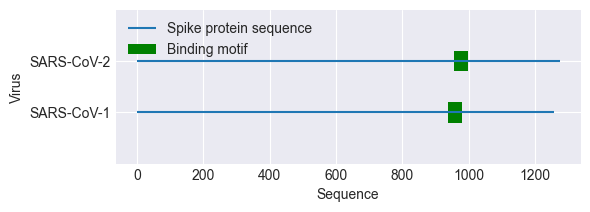

In [189]:
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.figsize"] = (6,2)
plt.hlines([0,1], 0, [len(cov1_types), len(cov2_types)], label="Spike protein sequence")
plt.yticks([0,1], ["SARS-CoV-1", "SARS-CoV-2"])
plt.ylabel("Virus")
plt.xlabel("Sequence")
plt.barh([0,1], width=[42,42], left=[937, 955], height=0.4, color="green", label="Binding motif")
plt.ylim([-1,2])
plt.legend()
plt.savefig("problem5.png")
# plt.barh([0,1], width=[300,300])

In [190]:
drug_comments = """We found the same sequence in both spike proteins that align with our target motif. This means that most likely the SARS-CoV-2 virus contains the EK1 binding motif.
"""

## Bonus Problem: Finding homologous genes with (slightly more) distant viruses

In Problem 4, we were able to find very good matches for most of our ORFs. Our reference genomes were very closely related to SARS-CoV-2. In this bonus problem, we will check if we can still characterize these ORFs using three less-related reference virus genomes: Human-MERS, Bat-CoV HKU5, and Hedgehog-CoV 2012-174/GER/2012. Report your predictions in the `orf_bonus_matches` variable. Additionally, you should report how confident you are in each prediction. Use your creativity to score your confidence in each alignment. Write your justifications and other observations to the `orf_bonus_comments` variable.

**[5 points]**

In [191]:
less_related_references = ["Human-MERS", "Bat-CoV HKU5", "Hedgehog-CoV 2012-174/GER/2012"]

In [192]:
cds = {}
for r in less_related_references:
    cds[r] = []
    for f in sequences[r].features:
        if f.type == 'CDS':
            cds[r].append((f.qualifiers['translation'][0], f.qualifiers['product'][0]))

In [193]:
covid_orfs = {}
for key, value in orf_candidates.items():
    covid_orfs[key] = translate_to_protein(covid.seq[value[1]:value[2]]) if value[0] == 1 else translate_to_protein(covid.seq.reverse_complement()[len(covid) - value[2] : len(covid) - value[1]])

In [194]:
candidates = {}
for orf_name, covid_orf in covid_orfs.items():
    print(orf_name)
    max_score = 0
    c_organism = ""
    h_gene = ""
    for candidate_name, candidate in cds.items():
        for protein in candidate:
            _, _, score = local_alignment(covid_orf, protein[0], l)
            if score > max_score:
                max_score = score
                c_organism = candidate_name
                h_gene = protein[1]
    print(max_score)
    candidates[orf_name] = {"closest-organism": c_organism, "homologous-gene": h_gene}

ORF-1
1419.0
ORF-2
322.0
ORF-3
1292.0
ORF-4
59.0
ORF-5
3682.0


In [195]:
candidates

{'ORF-1': {'closest-organism': 'Hedgehog-CoV 2012-174/GER/2012',
  'homologous-gene': 'ORF1ab polyprotein'},
 'ORF-2': {'closest-organism': 'Human-MERS',
  'homologous-gene': 'membrane protein'},
 'ORF-3': {'closest-organism': 'Human-MERS',
  'homologous-gene': 'spike protein'},
 'ORF-4': {'closest-organism': 'Human-MERS',
  'homologous-gene': '1AB polyprotein'},
 'ORF-5': {'closest-organism': 'Human-MERS',
  'homologous-gene': '1AB polyprotein'}}

In [196]:
orf_bonus_matches = {
    "ORF-1": {
        # These are just example solutions. You have to replace them with the correct answers
        "closest-organism": "Hedgehog-CoV 2012-174/GER/2012", 
        "homologous-gene": "ORF1ab polyprotein",
        "confidence": 4  # not confident: 1 -- 5 : completely confident
    },
    "ORF-2": {
        "closest-organism": "Human-MERS",
        "homologous-gene": "membrane protein",
        "confidence": 2
    },
    "ORF-3": {
        "closest-organism": "Human-MERS",
        "homologous-gene": "spike protein",
        "confidence": 3
    },
    "ORF-4": {
        "closest-organism": "Human-MERS",
        "homologous-gene": "1AB polyprotein",
        "confidence": 1
    },
    "ORF-5": {
        "closest-organism": "Human-MERS",
        "homologous-gene": "1AB polyprotein",
        "confidence": 5
    },
}
orf_bonus_comments = """
The most scored alignment and the least scored ORF were most similar to Human-MERS 1AB polyprotein.
"""